<a href="https://colab.research.google.com/github/qianjing2020/DS-Unit-2-Kaggle-Challenge/blob/master/JingQian_DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
# find baseline accuracy
from sklearn.metrics import accuracy_score
target ='shot_made_flag'
majority_class = df[target].mode()
baseline = [majority_class]*len(df)
baseline_accu = accuracy_score(df[target], baseline)
print(f'Baseline accuracy score is {baseline_accu}')

Baseline accuracy score is 0.5270812437311936


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df['game_date']=pd.to_datetime(df['game_date'])
test_start = pd.to_datetime('2018-10-01')
test_end = pd.to_datetime('2019-06-30')

test_period = (df['game_date']>test_start) & (df['game_date']<=test_end)
test = df[test_period]
test.shape

(1709, 20)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
import pandas_profiling

profile_report = df.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
# introduce five new feature: 
# home court advantage 
# seconds remaining in period
# seconds remaining in game
# home court disadvantage and seconds remaining in period
df['home_court']=df['htm']=='GSW'
df['seconds_remaining_period']=60*df['minutes_remaining']+df['seconds_remaining']
df['seconds_remaining_game']=12*60*(4-df['period'])+60*df['minutes_remaining']+df['seconds_remaining']
df['near_game'] = df['seconds_remaining_game']<60
df['no_home_court_near_game'] = df['home_court'] & df['near_game']
df.head(99)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,...,game_date,htm,vtm,season_type,scoremargin_before_shot,home_court,seconds_remaining_period,seconds_remaining_game,near_game,no_home_court_near_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,2009-10-28,GSW,HOU,Regular Season,2.0,True,685,2845,False,False
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,2009-10-28,GSW,HOU,Regular Season,0.0,True,571,2731,False,False
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,2009-10-28,GSW,HOU,Regular Season,-4.0,True,362,2522,False,False
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,2009-10-28,GSW,HOU,Regular Season,-4.0,True,589,2029,False,False
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,2009-10-28,GSW,HOU,Regular Season,0.0,True,139,1579,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,20900204,87,Stephen Curry,1,4,43,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Left Side(L),...,2009-11-24,DAL,GSW,Regular Season,-3.0,False,283,2443,False,False
95,20900204,171,Stephen Curry,2,10,2,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),...,2009-11-24,DAL,GSW,Regular Season,-0.0,False,602,2042,False,False
96,20900204,196,Stephen Curry,2,7,16,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,2009-11-24,DAL,GSW,Regular Season,-0.0,False,436,1876,False,False
97,20900204,226,Stephen Curry,2,4,28,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,2009-11-24,DAL,GSW,Regular Season,1.0,False,268,1708,False,False


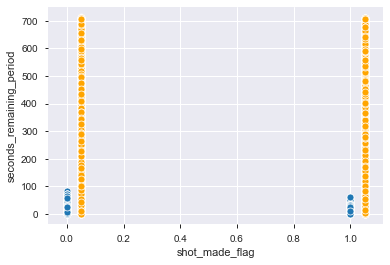

In [0]:
# check feature target relationship
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
sns.scatterplot(df[target], df['shot_distance']);
sns.scatterplot(df[target]+0.05, df['seconds_remaining_period'], color='orange');

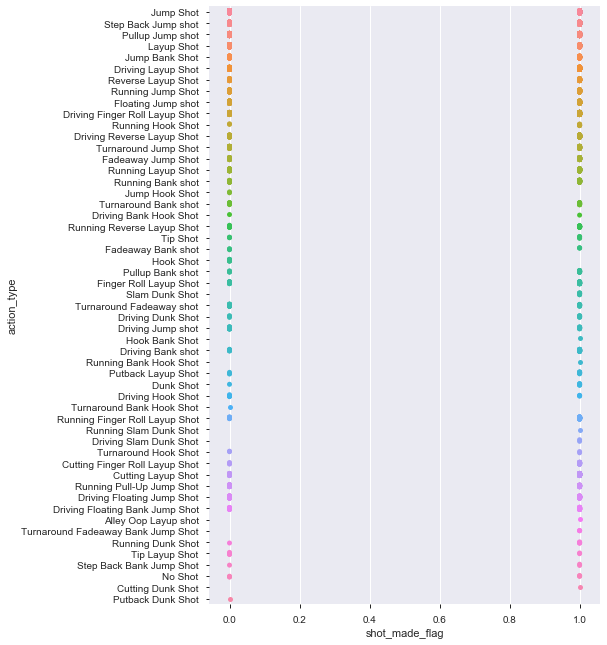

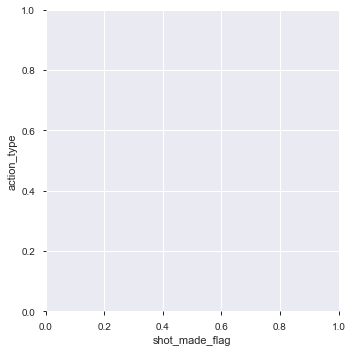

In [0]:
fig,ax = plt.subplots(figsize=(7, 11))
sns.catplot(y='action_type', x=target, data=df, ax=ax);
plt.show()

In [0]:
# feature engineering
df_features = df.drop(columns = target)
# numerical features
num_features = df_features.select_dtypes(include='number').columns.tolist()
# cardinal features
cardinal_features = df_features.select_dtypes(exclude='number').nunique()
# categorical features
cat_features = cardinal_features[cardinal_features<55].index.tolist()

features = num_features+cat_features

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
# split for train, test
train_period = (df['game_date']> pd.to_datetime('2009-10-01')) & \
               (df['game_date']<=pd.to_datetime('2018-06-30'))

test_period = (df['game_date']> pd.to_datetime('2018-10-01')) & \
               (df['game_date']<=pd.to_datetime('2019-06-30'))

train = df[train_period]
test = df[test_period]

In [0]:
# get x and y
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
# make pipeline, use randomsearchcv to optimize hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [60, 80, 100],
    'randomforestclassifier__max_depth': [None, 5, 10],
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter = 100, 
    cv=5,
    scoring='accuracy',
    verbose = 10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/ajaysonar/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   59.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

In [0]:
# optimized hyperparameters: 
print('Best hyperparameters combination: ', search.best_params_)

Best hyperparameters combination:  {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_depth': 10}


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
# validation accuracy
print('Validation accuracy based on 5-folds cross validation', search.best_score_)


Validation accuracy based on 5-folds cross validation 0.6562168340272675


## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
# use the best found model to predict
pipeline = search.best_estimator_
# find test accuracy
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Accuracy score for test set is', accuracy_score(y_test, y_pred))

Accuracy score for test set is 0.6325336454066706


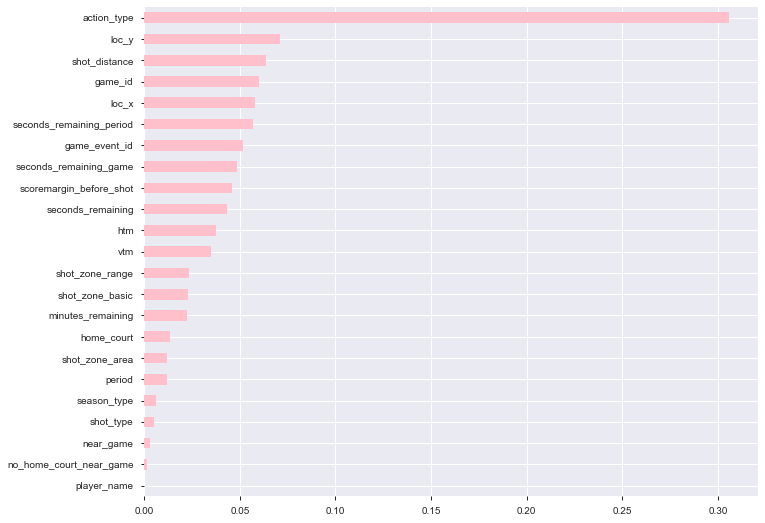

In [0]:
# visualize feature importances
import matplotlib.pyplot as plt
model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_cols = encoder.transform(X_test).columns

importances = pd.Series(model.feature_importances_, encoded_cols)
plt.figure(figsize=(11, 9))
importances.sort_values().plot.barh(color='pink')

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
import numpy as np
data = np.array([[85, 58], [8, 36]])
table = pd.DataFrame(data, 
                     columns = ['Predicted Negative', 'Predicted Positive'],
                     index = ['Actual Negative', 'Actual Positive'])
table

,Predicted Negative,Predicted Positive
Actual Negative,85,58
Actual Positive,8,36


In [0]:
accuracy = np.diag(table).sum()/table.sum().sum()
print(f'Accuracy = {accuracy}')

Accuracy = 0.6470588235294118


### Calculate precision

In [0]:
precision = table/table.sum()
print('Precision \n', precision)

Precision 
                  Predicted Negative  Predicted Positive
Actual Negative            0.913978            0.617021
Actual Positive            0.086022            0.382979


### Calculate recall

In [0]:
recall = np.divide(table, table.T.sum())
print('Recall \n', recall)

Recall 
                  Predicted Negative  Predicted Positive
Actual Negative            0.594406            1.318182
Actual Positive            0.055944            0.818182
